# 🚜 Bulldozer Price Prediction

A Machine Learning Project

## 1. Problem Definition

This project will focus on designing a model that can answer the following questions:
> Can a bulldozer's sale price be predicted base on it's individual characteristics? Can a machine learning model be developed to make these predictions?

## 2. Data

The data for this project comes from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers

*Three main datasets:*

* Train.csv, the training dataset
* Valid.csv, the validation dataset
* Test.csv, the final test dataset

## 3. Evaluation Metric

The evaluation metric for this project is the **RMSLE** (root mean squared log error) between the actual and predicted auction prices.

**NOTE** The goal for most evaluation metrics is to minimize the error rate. 

## 4. Features

A data dictionary is provided which contains all features of the dataset. This dictionary is available in the /data folder as "Data Dictionary.xlsx"

# Procedures

1. Import the training dataset, validation dataset, and test dataset, separately
2. Check all sets for missing values and datatypes
3. Build a function to preprocess the data
    * parse dates that exist
    * expand dates to year, month, day, etc
    * numeric columns: fill missing cells with median of columns
    * numeric columns: add "is_missing" column for missing values (bools)
    * categorical columns: turn them into categories
    * categorical columns: add "is_missing" column for missing values (bool)
4. Compare transformed datasets
    * ensure columns and order match
    * ensure all have same number of columns
5. Make X_train, y_train, X_val, y_val, X_test, y_test sets (where applicable)
6. Build the model (RandomForestRegression or similar)
7. Fit the model with the "train" sets, score the model with the "train" sets
8. Evaluate (use a function for this)
9. Run RandomizedSearchCV with a grid of options
    * Run for larger set of intervals to best determine params
    * Get Best Param
10. Create a new model with the best params
    * Fit with X_train and y_train
11. Compare evaluation scores
12. Use validation dataset to test prediction ability of model
13. Continue to tune (try GridSearchCV)
14. Run prediction on "Test" dataset
15. Calculate and plot feature importance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Evalutation Function

In [2]:
# import
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# build the function to calc mean squared log error
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true_labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Valid MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Valid RMSLE": rmsle(y_valid, val_preds),
             "Training R^2": r2_score(y_train, train_preds),
             "Valid R^2": r2_score(y_valid, val_preds)}

    
    return scores


### Preprocessing Function

In [1]:
# get test data in the same format as train and valid datasets
# fill missing, convert types

def preprocess_data(df):
    '''
    Performs transformations on the dataframe and returns the transformed df
    '''
    
    # break apart the 'saledate' column into individual properties
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    # drop the original column 'saledate'
    df.drop("saledate", axis=1, inplace=True)
    
    # fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # add a binary column which tells if the 
                # data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # fill categorical missing data and turn categories into numbers\
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1

    return df

### Plotting Feature Importance

In [4]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # plot
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()
        

## Importing Data

In [184]:
# Import datasets, parse dates

train = pd.read_csv("data/Train.csv", low_memory=False, parse_dates=["saledate"])
valid = pd.read_csv("data/Valid.csv", low_memory=False, parse_dates=["saledate"])
valid_sol = pd.read_csv("data/ValidSolution.csv", low_memory=False)
test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])

In [117]:
test_ = preprocess_data(test)
valid_ = preprocess_data(valid) 
train_ = preprocess_data(train)

In [186]:
len(train)

401125

### Check Columns

All dataframes **must** have same number of columns **and** same order of columns.

In [118]:
test_.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [34]:
train_.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1139246,66000,999089,3157,121,3.0,2004,68.0,2,950,...,True,True,True,True,True,True,True,True,False,False
1,1139248,57000,117657,77,121,3.0,1996,4640.0,2,1725,...,True,True,True,True,True,True,True,True,False,False
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,1,331,...,True,True,True,True,True,True,True,True,True,True
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,1,3674,...,True,True,True,True,True,True,True,True,True,True
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,3,4208,...,True,True,True,True,True,True,True,True,True,True


In [35]:
valid_.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1222837,902859,1376,121,3,1000,0.0,0,294,122,...,False,False,False,False,False,True,True,True,True,True
1,1222839,1048320,36526,121,3,2006,4412.0,3,1612,728,...,False,False,False,False,False,True,True,True,True,True
2,1222841,999308,4587,121,3,2000,10127.0,3,161,75,...,False,False,False,False,False,True,True,True,True,True
3,1222843,1062425,1954,121,3,1000,4682.0,2,687,248,...,False,False,False,False,False,True,True,True,True,True
4,1222845,1032841,4701,121,3,2002,8150.0,3,398,156,...,True,True,True,True,True,True,True,True,False,False


## Exploring the Data

In [169]:
years = train_["saleYear"].unique().tolist()
years.sort(), len(years)

(None, 23)

In [168]:
month = []
year = []
for i in range(1, 13, 1):
    month.append(train_.loc[train_["saleMonth"].eq(i), "SalePrice"].mean()) 

for j in years:
    year.append(train_.loc[train_["saleYear"].eq(j), "SalePrice"].mean())


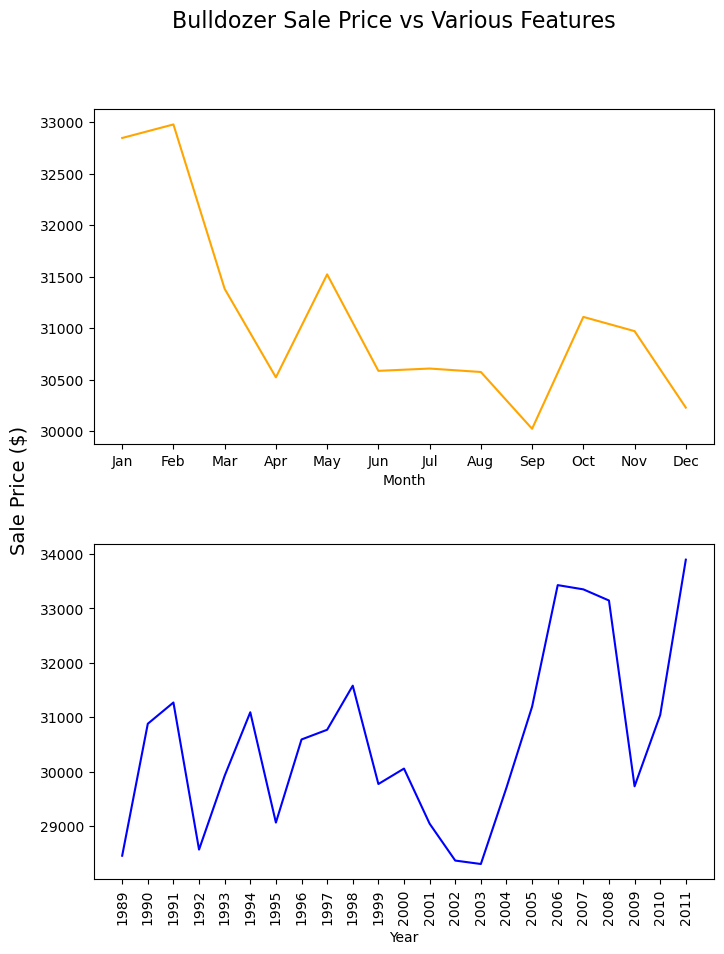

In [182]:
fig, (ax3, ax4) = plt.subplots(2,1, figsize=(8,10))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

fig.suptitle("Bulldozer Sale Price vs Various Features", fontsize=16)
fig.supylabel("Sale Price ($)", fontsize=14)

ax3.plot(month, c="orange")
ax3.set_xticks(np.arange(0,12,1), labels=months);
# ax3.set_ylabel("Sale Price ($)")
ax3.set_xlabel("Month")

ax4.plot(year, c="blue")
ax4.set_xticks(np.arange(0,23,1), labels=years, rotation=90)
# ax4.set_ylabel("Sale Price ($)")
ax4.set_xlabel("Year");

In [147]:
train_.loc[train_["saleMonth"].eq(1), "SalePrice"].mean()

32845.542357552

In [148]:
train_.loc[train_["saleMonth"].eq(6), "SalePrice"].mean()

30584.621766393877

## Modify the Data

In [36]:
# Check which columns 'valid_' is missing
# 'SalePrice' is our 'y' set for testing, it will be droped on model creation, ignore for now

set(train_.columns) - set(valid_.columns)

{'SalePrice', 'auctioneerID_is_missing'}

In [38]:
# create a temp df with missing column dropped

train_mod = train_.drop("auctioneerID_is_missing", axis=1)

In [39]:
# add the dropped column back, will be placed at the end

train_mod["auctioneerID_is_missing"] = train_["auctioneerID_is_missing"]

In [47]:
# add the same column to 'valid_', fill with 'false', will be placed at the end
# fill with 'false' bc all values were present, no "is_missing" column was created initially

valid_["auctioneerID_is_missing"] = False
test_["auctioneerID_is_missing"] = False

In [48]:
# reassign the 'train_' dataset

train_ = train_mod

In [49]:
len(train_.columns), len(valid_.columns), len(test_.columns)

(103, 102, 102)

## Build and Fit the Model

In [82]:
%%time

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

X_train = train_.drop("SalePrice", axis=1)
y_train = train_["SalePrice"]

model.fit(X, y)

CPU times: total: 1min 27s
Wall time: 6.09 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [83]:
# score
model.score(X, y)

0.8611282073934683

In [84]:
# make sets for scoring eval
X_train = train_.drop("SalePrice", axis=1)
y_train = train_["SalePrice"]
X_valid = valid_
y_valid = valid_sol["SalePrice"]

In [85]:
# evaluation
show_scores(model)

{'Training MAE': 5548.337219520101,
 'Valid MAE': 9870.13091506092,
 'Training RMSLE': 0.25729129016365265,
 'Valid RMSLE': 0.3945193505788297,
 'Training R^2': 0.8611282073934683,
 'Valid R^2': 0.6558038240154331}

In [92]:
# predict on 'validation' dataset
valid_preds = model.predict(X_valid)

In [93]:
# compare lengths, ensure they are the same
len(valid_preds), len(y_valid)

(11573, 11573)

In [99]:
# find the difference between predictions and actuals
difference = []
for i in range(len(valid_preds)):
    difference.append(valid_preds[i] - y_valid[i])

In [100]:
# create dataframe to view differences
compare = pd.DataFrame({"Predictions": valid_preds,
                      "Actual": y_valid,
                       "Difference": difference})
compare.head(10)


,Predictions,Actual,Difference
0,29162.5,31000.0,-1837.5
1,73305.0,54000.0,19305.0
2,42435.0,26500.0,15935.0
3,29940.0,10000.0,19940.0
4,36383.0,35000.0,1383.0
5,11811.0,8000.0,3811.0
6,26202.5,33000.0,-6797.5
7,27687.5,33500.0,-5812.5
8,17495.5,66000.0,-48504.5
9,31111.0,25000.0,6111.0


In [104]:
# find the mean of the differences
np.mean(difference)

-3727.3270785448885

## Tuning the Model

In [105]:
from sklearn.model_selection import RandomizedSearchCV

In [106]:
%%time
grid = {"n_estimators": np.arange(10, 100, 10),
       "max_depth": [None, 3, 5, 10],
       "min_samples_split": np.arange(2, 20, 2),
       "min_samples_leaf": np.arange(1, 20, 2),
       "max_features": [0.5, 1, "sqrt", None],
       "max_samples": [25000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=grid,
                             n_iter=50,
                             cv=5,
                             verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 3min 28s
Wall time: 7min 22s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt', None],
                                        'max_samples': [25000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [107]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_samples': 25000,
 'max_features': 0.5,
 'max_depth': None}

In [108]:
show_scores(rs_model)

{'Training MAE': 5193.2010064153055,
 'Valid MAE': 10199.303072702913,
 'Training RMSLE': 0.2414238137145656,
 'Valid RMSLE': 0.3925351947398932,
 'Training R^2': 0.8765075966051655,
 'Valid R^2': 0.640142636897514}

In [109]:
show_scores(model)

{'Training MAE': 5548.337219520101,
 'Valid MAE': 9870.13091506092,
 'Training RMSLE': 0.25729129016365265,
 'Valid RMSLE': 0.3945193505788297,
 'Training R^2': 0.8611282073934683,
 'Valid R^2': 0.6558038240154331}

## Feature Importance

In [111]:
ideal_model = RandomForestRegressor(n_estimators=60,
                                   min_samples_split=8,
                                   min_samples_leaf=3,
                                   max_samples=25000,
                                   max_features=0.5,
                                   max_depth=None,
                                   random_state=42,
                                   n_jobs=-1)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, max_samples=25000, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=60, n_jobs=-1,
                      random_state=42)

In [112]:
ideal_model.feature_importances_

array([3.39647432e-02, 2.28476498e-02, 4.22824448e-02, 1.76256906e-03,
       4.19191686e-03, 1.99765535e-01, 3.40014507e-03, 1.23376193e-03,
       3.87404096e-02, 3.61111388e-02, 6.66935748e-02, 3.96744958e-03,
       1.51285566e-02, 1.59939355e-01, 4.03538714e-02, 7.52939053e-03,
       2.49074858e-03, 5.10298276e-03, 3.10855427e-03, 7.56846727e-02,
       5.30977425e-04, 7.32304220e-05, 1.28806109e-03, 2.29041858e-04,
       1.03493392e-03, 1.81288587e-05, 1.50543183e-03, 7.19714781e-03,
       1.64404193e-03, 1.31507373e-03, 3.67888994e-03, 1.93043168e-03,
       4.87602221e-03, 1.56413183e-03, 1.10172853e-03, 8.82167208e-03,
       1.23978995e-03, 1.07684131e-02, 1.76517504e-03, 1.97597383e-03,
       1.02606735e-03, 1.12165527e-03, 1.29884417e-03, 8.70746541e-04,
       3.93229855e-04, 3.96472588e-04, 2.68129536e-04, 2.53268514e-03,
       1.04737990e-03, 2.40608266e-04, 1.81480472e-04, 6.27209340e-02,
       4.70110155e-03, 7.86118029e-03, 3.84571020e-03, 1.02978518e-02,
      

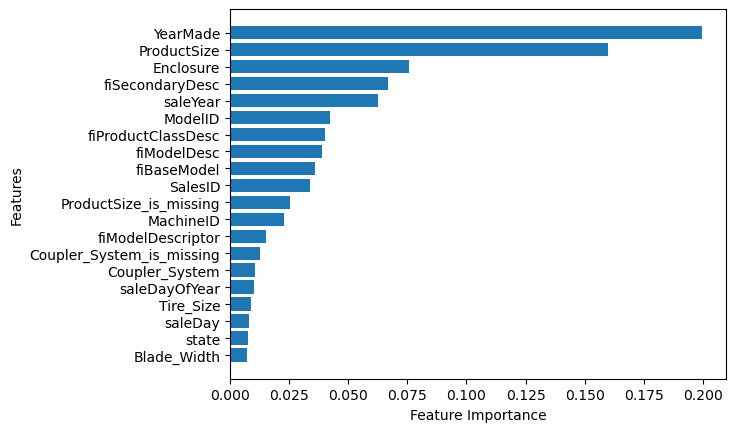

In [113]:
plot_features(X_train.columns, ideal_model.feature_importances_)